# Extract dataframe

In order to mimick dg_transport, benchmark use zero_time_step and 4 calls of update_solution. 
Therefore initially there were two items for every group. One with n_calls==1 (zero_time_step) 
and one with n_calls=4 (4 x update_solution). The loading script has been hacked to skip "ZERO-TIME STEP" tag
However all tags excepting "full_mesh" are called in 4 assembly loops.


In [9]:
# zip archive or pattern
#profiler_files="dg_asm.zip"
profiler_files="../../../bin/benchmark/dg_asm-1-bench_profiler_*.json"

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import dg_asm_bench_postprocess as bp

# load and process Profiler JSON output
df_orig = df = bp.load_profiler_data(profiler_files)

from IPython.display import Markdown, display
    
def table_overview(df):
    for col in df.columns:
        unique = df[col].unique()
        is_factor =  all([type(v) is str for v in unique])
        value_set = np.sort(unique)
        np.set_printoptions(threshold=30)
        value_set = np.array2string(value_set, precision=2, separator=',')
        display(Markdown(f'**{col}**: {value_set}'))
                

table_overview(df_orig)

**branch**: ['DF_variant_benchmark_asm']

**commit**: ['cde3abf']

**run_id**: [1,2,3]

**domain_shape**: ['B','L']

**mesh_size**: ['L','M','S']

**spacedim**: ['2D','3D']

**uniformity**: ['refined','uniform']

**n_mesh_elements**: [  2770.,  2806.,  2889.,  2918.,  3041.,  3046.,  3049.,  3392., 29250.,
  29346., 30046., 30168., 30186., 30574., 31423., 31914.,301689.,302320.,
 304838.,305121.,305984.,308574.,310479.,316110.]

**n_repeats**: [ 1,10]

**field_variant**: ['const','model']

**assembly_variant**: ['ComputeLocal','EvalFields','FullAssembly']

**assembly_class**: ['','Mass','Sources','Stiffness']

**tag**: ['MassAssembly','SourcesAssembly','StiffnessAssembly',
 'add_integrals_to_patch','assemble_fluxes_boundary',
 'assemble_fluxes_elem_elem','assemble_fluxes_elem_side',
 'assemble_volume_integrals','cache_update','create_patch','full_mesh']

**number_of_calls**: [      1,      4,     10,...,1298992,1301748,1309856]

**integral_type**: ['','boundary_side','cell','dimjoin','edge']

**time**: [8.05e-05,8.09e-05,8.12e-05,...,9.81e+01,9.81e+01,9.99e+01]

**time_fraction**: [1.01e-04,1.05e-04,1.07e-04,...,1.00e+00,1.00e+00,1.00e+00]

**time_fraction_of_reminder**: [0.  ,0.  ,0.  ,...,0.2 ,0.25, nan]

**parent_tag**: ['ComputeLocal_model','EvalFields_const','EvalFields_model',
 'FullAssembly_model','MassAssembly','SourcesAssembly','StiffnessAssembly',
 'assembly']

**level**: [5,8,9]

# Basic dataset modifications
- rename some columns
- extract `branch` and `commit` columns into `flow123d_version` variable, drop these columns
- fix `n_el` type
- merge `shape` and `uniformity` columns
- Divide 'time' and 'number_of_calls' by 'n_repeats'


In [3]:
# Get benchmarked sources version.
df = df_orig.copy()
assert df['branch'].nunique() == 1
assert df['commit'].nunique() == 1
flow123d_version = f"{df['branch'].loc[0]}_{df['commit'].loc[0]}"
print("Benchmarked Flow123d version: ", flow123d_version)
df.drop(columns=["branch", "commit"], inplace=True)

# rename some columns:
col_map = dict(spacedim='dim', mesh_size='size', domain_shape='shape', n_mesh_elements='n_el', 
               number_of_calls='n_calls')
df.rename(columns=col_map, inplace=True)

# int values for 'n_el', 'n_calls' columns
df['n_el'] = df['n_el'].astype(int)

# merge mesh shape and uniformity
df['mesh_type'] = [f"{row['shape']}_{row['uniformity']}" for index, row in df.iterrows()]
df.drop(columns=["shape", "uniformity"], inplace=True)

def apply_n_repeats(df):
    repeated_cols = ['n_calls', 'time']
    for c in repeated_cols:
        df[c] /= df['n_repeats']
    df['n_calls'] = df['n_calls'].astype(int)
    df.drop(columns=['n_repeats'], inplace=True)
    return df

df = apply_n_repeats(df)


table_overview(df)


Benchmarked Flow123d version:  DF_variant_benchmark_asm_cde3abf


**run_id**: [1,2,3]

**size**: ['L','M','S']

**dim**: ['2D','3D']

**n_el**: [  2770,  2806,  2889,  2918,  3041,  3046,  3049,  3392, 29250, 29346,
  30046, 30168, 30186, 30574, 31423, 31914,301689,302320,304838,305121,
 305984,308574,310479,316110]

**field_variant**: ['const','model']

**assembly_variant**: ['ComputeLocal','EvalFields','FullAssembly']

**assembly_class**: ['','Mass','Sources','Stiffness']

**tag**: ['MassAssembly','SourcesAssembly','StiffnessAssembly',
 'add_integrals_to_patch','assemble_fluxes_boundary',
 'assemble_fluxes_elem_elem','assemble_fluxes_elem_side',
 'assemble_volume_integrals','cache_update','create_patch','full_mesh']

**n_calls**: [      1,      4,    112,...,1298992,1301748,1309856]

**integral_type**: ['','boundary_side','cell','dimjoin','edge']

**time**: [8.05e-06,8.09e-06,8.12e-06,...,9.81e+01,9.81e+01,9.99e+01]

**time_fraction**: [1.01e-04,1.05e-04,1.07e-04,...,1.00e+00,1.00e+00,1.00e+00]

**time_fraction_of_reminder**: [0.  ,0.  ,0.  ,...,0.2 ,0.25, nan]

**parent_tag**: ['ComputeLocal_model','EvalFields_const','EvalFields_model',
 'FullAssembly_model','MassAssembly','SourcesAssembly','StiffnessAssembly',
 'assembly']

**level**: [5,8,9]

**mesh_type**: ['B_refined','B_uniform','L_refined','L_uniform']

# Mesh times comparison 
- plot `full_mesh` time for mesh and run ID variants.


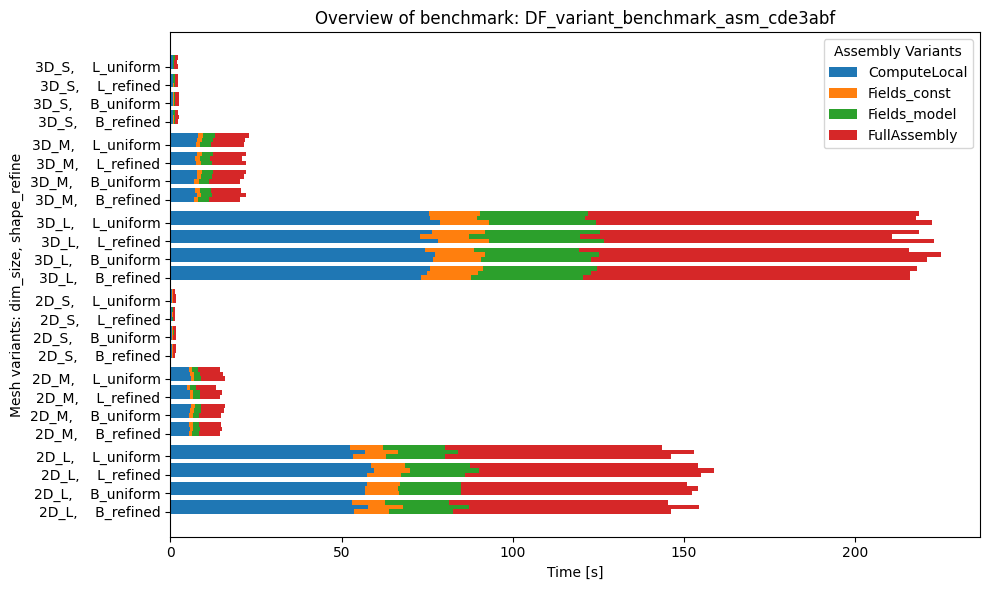

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def mesh_cases_plot(df, time_label):
    cases_cols = ['dim_size', 'mesh_type', 'run_id', 'variant']
    stacked_df = df.groupby(cases_cols)['time'].sum().unstack('variant').fillna(0)
    n_rows = len(stacked_df)
    
    # for grouping by position on Y axis
    level_labels = [l for l in stacked_df.index.levels]
    level_vals = [pd.Categorical(l).codes for l in stacked_df.index.levels]
    int_df = stacked_df.copy()
    int_df.index = stacked_df.index.set_levels(level_vals, level=[0, 1, 2])

    bar_width = 0.5
    steps = []
    ticks = []
    tick_labels = []
    last_idx = (0,-1,-1)
    step = np.array([0.5, 0.5, bar_width])
    for idx in int_df.index.drop_duplicates():
        diff = np.array(idx) - np.array(last_idx)
        last_idx = idx
        if diff[1] != 0:
            ticks.append(len(steps))
            tick_labels.append(f'{level_labels[0][idx[0]]}, {level_labels[1][idx[1]]: >12}')
        steps.append(np.sum(step[diff != 0]))
        
    positions = np.cumsum(steps)
    ticks = positions[ticks]        
    
    # Initialize a color palette
    palette = sns.color_palette("tab10", len(stacked_df.columns))
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
  
    # Create stacked bars
    bottom = np.zeros(n_rows)
    for j, col in enumerate(stacked_df.columns):
            ax.barh(positions, stacked_df[col], bar_width, left=bottom, color=palette[j], label=col)
            bottom += stacked_df[col]
    
    ax.set_yticks(ticks)
    ax.set_yticklabels(tick_labels)
    ax.legend(title='Assembly Variants')
    ax.set_xlabel(time_label)
    ax.set_ylabel('Mesh variants: dim_size, shape_refine')
    ax.set_title(f'Overview of benchmark: {flow123d_version}')
    
    # Display
    fig.tight_layout()
    plt.show()
    return fig
    

df_sumrun = df[df['tag'] == 'full_mesh'].copy()
df_sumrun['dim_size'] = df_sumrun['dim'] + '_' + df_sumrun['size']
def variant(row):
    var = row['assembly_variant']
    if var == 'EvalFields':
        var = f"Fields_{row['field_variant']}"
    return var

df_sumrun['variant'] = df.apply(variant, axis=1)
fig = mesh_cases_plot(df_sumrun, 'Time [s]')

## Relative Mesh comparison
Comparison of time per element allows us to see:

- nearly no difference between mesh sizes, i.e., almost zero assembly overhead or
  additional 'fit to the cache' advantages of small meshes.
  Fitting all to the cache probably could not happen as individual data are allocated at different places.
  It seems more probable that even for small meshes (S ~ 1000 elements)
  the calculation has some cache misses. Needs better investigation.

- significant impact of 3D calculation. 3D has about 4/3 times more DOFs, the increase is slightly higher,
  possibly due to a larger increase in the number of quadrature points o
  
- very small impact of `mesh_type`

- the significant impact of `run_id` we should rather increase the number of runs to 5. Memory layout could
  have some impact. Ideally, we should minimize this impact by own arena allocator used for
  assembly structures on the patch.   

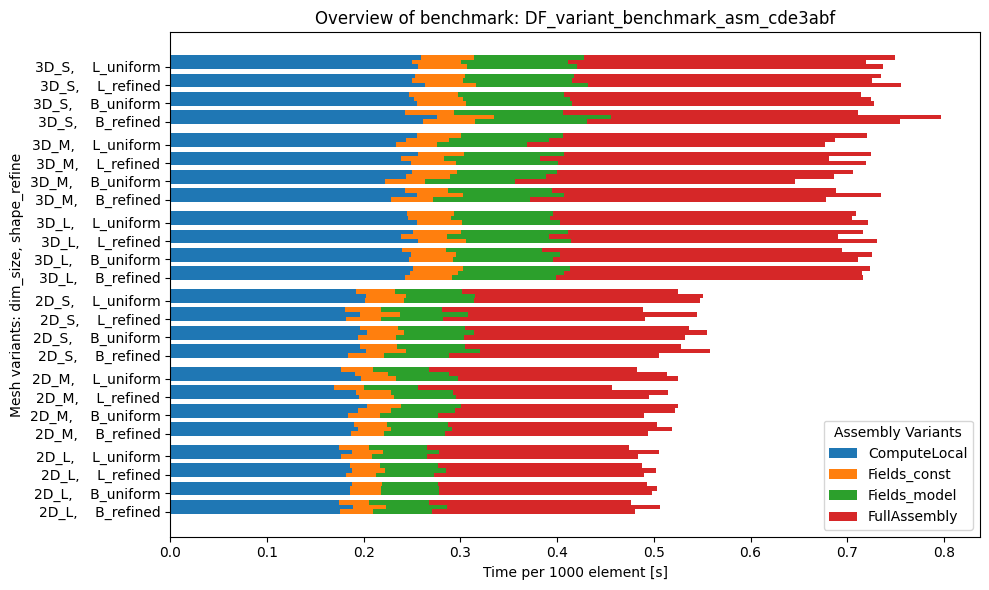

In [5]:
df_reltime = df_sumrun.copy()
df_reltime['time'] = df_reltime['time'] / df_reltime['n_el'] * 1000
fig = mesh_cases_plot(df_reltime, 'Time per 1000 element [s]')
fig.savefig("overview_plot.pdf")

# Aggregate runs
- compute suitable position and variance indicators
- report (tags) with high variability and high time fraction

Se that there is much higher `run_ID` variability at a detailed level and even for long time frames.

In [6]:
index_cols = ['dim', 'mesh_type', 'size', 'assembly_variant', 'field_variant', 'assembly_class', 'integral_type', 'tag']
grouped = df.groupby(index_cols)
#print(grouped.size())
assert all(grouped.size() == 3)
# Available groups
# print(grouped.groups.keys())
# Rows in a single group:
# display(grouped.get_group(('2D', 'B_refined', 'L', 'ComputeLocal', 'model', 'Mass', '', 'MassAssembly')))

def get_median_row(group):
    min_t = group['time'].min()
    median_t = group['time'].median()
    max_t = group['time'].max()
    row = group[group['time'] == min_t]
    row['Err'] = (median_t - min_t) / min_t
    return row

# Apply the custom function to each group
df_med = grouped.apply(get_median_row).reset_index(drop=True)
#display(result)
df_med.drop(columns=['run_id'], inplace=True)
df_med.drop(columns=['n_calls', 'integral_type', 'n_el', 'time_fraction_of_reminder', 'parent_tag', 'level'], inplace=True)

# Sort the DataFrame by column 'A'
# There are many items with big error and big time fraction.
sorted_df = df_med.sort_values(by='Err', ascending=False)
big_err = sorted_df[sorted_df['Err'] > 0.1]
big_err_and_fraction = big_err[big_err['time_fraction'] > 0.05]
# Display the sorted DataFrame
display(big_err_and_fraction.head(30))


# Result kee run_id and try to plot all three values in plots.

,size,dim,field_variant,assembly_variant,assembly_class,tag,time,time_fraction,mesh_type,Err
1639,M,3D,const,EvalFields,Sources,assemble_volume_integrals,0.004627,0.064983,B_uniform,0.262325
1054,M,2D,model,EvalFields,Mass,create_patch,0.016018,0.163491,L_uniform,0.218199
1486,S,3D,model,FullAssembly,Sources,cache_update,0.001285,0.062361,B_refined,0.197456
1931,M,3D,const,EvalFields,Mass,assemble_volume_integrals,0.004842,0.066232,L_refined,0.188246
725,M,2D,const,EvalFields,,full_mesh,0.888285,0.999999,L_refined,0.181281
260,S,2D,model,EvalFields,Sources,add_integrals_to_patch,0.003043,0.424983,B_refined,0.168463
451,M,2D,model,EvalFields,Mass,MassAssembly,0.101697,0.088873,B_uniform,0.154284
718,M,2D,model,ComputeLocal,Stiffness,add_integrals_to_patch,0.176840,0.053228,L_refined,0.148648
1554,L,3D,model,EvalFields,Mass,create_patch,0.188990,0.126537,B_uniform,0.146808
2202,M,3D,model,ComputeLocal,Mass,add_integrals_to_patch,0.037948,0.081918,L_uniform,0.143790


# Detailed view

1. reduce assembly variants to new tags having complete decomposition of a single assembly
2. separate plot for each `assembly_class`
3. group by:
   `dim_size`, `tag`
4. in every group points from: reduction, runs, mesh_type `

In [7]:
# reduce columns: assembly_variant, field_variant, integral_type
# to tags: 
# field_const, field_model
# <integral>_loop, <integral>_local, <integral>_global
# reminder (of assembly)

new_rows = {}

def add_row(group, orig_row_mask, tag, time_subtrack):
    """
    Add new row to the dataset by taking `orig_row_mask` from `group`
    setting the `tag` and subtrack `time_subtrack` from the `time` column.
    We return original `time` value.
    """
    orig = group[orig_row_mask].to_dict('list')
    orig_time = np.mean(orig['time'])
    for i in range(len(orig['time'])):
        #print(new_row)
        orig['time'][i] -= time_subtrack
        orig['tag'][i] = tag
    for key, item_dict in orig.items():
        col = new_rows.setdefault(key, [])
        col.extend(item_dict)
    return orig_time
    

# check same time of some tags between variants
index_cols = ['run_id', 'dim', 'mesh_type', 'size',  'assembly_class']
grouped = df.groupby(index_cols)

# Add column with assembly total times
#
for name, group in grouped:
    # skip full_mesh group
    if name[-1] == '':
        assert all(group['tag'] == 'full_mesh')
        continue
    main_tag = f"{name[-1]}Assembly"
    asm_var = group['assembly_variant']    
    field_var = group['field_variant']
    tags = group['tag']
    integral = group['integral_type']

    # compute reminders
    reminders = {
        'field_const':('EvalFields', 'const'),
        'field_model':('EvalFields', 'model'),
        'local': ('ComputeLocal', 'model'),
        'global': ('FullAssembly', 'model'),}
    rm = {}
    for key, (av, fv) in reminders.items():
        subgroup = group[(asm_var == av) & (field_var == fv)]
        assembly_time = subgroup[subgroup['tag'] == main_tag]['time'].item()
        total = np.sum(subgroup['time']) - assembly_time
        reminder = assembly_time - total
        rm[key] = reminder #, reminder/total)
    rm_mean = np.mean(list(rm.values()))
    rm_std = np.std(list(rm.values()))
    print(f"{repr(name):<40}  reminder: {rm_mean:<10.5} sd: {300*rm_std/rm_mean:3.0f}%")
            
    
    # Patch creation
    add_row(group, tags == 'add_integrals_to_patch', 'colect_patch', 0.0)
    add_row(group, tags == 'create_patch', 'create_patch', 0.0)
    # Fields - Cache Update
    field_const_mask = (asm_var == 'EvalFields') & (tags == 'cache_update') & (field_var == 'const')
    t_field_const = add_row(group, field_const_mask, 'field_const', 0.0)
    field_model_mask = (asm_var == 'EvalFields') & (tags == 'cache_update') & (field_var == 'model')
    add_row(group, field_model_mask, 'field_model',  t_field_const)

    # Assembly integrals
    for it in integral.unique():
        if it == '':
            continue
        loop_mask = (asm_var == 'EvalFields') & (integral == it)
        t_loop = add_row(group, loop_mask, f'{it}_loop', 0.0)
        local_mask = (asm_var == 'ComputeLocal') & (integral == it)
        t_local = add_row(group, local_mask, f'{it}_local', t_loop)
        global_mask = (asm_var == 'FullAssembly') & (integral == it)
        add_row(group, global_mask, f'{it}_global', t_local)
    
    # Reminder - taking mean value, bute there could be huge deviances, but mostly for small values    
    assembly_mask = (asm_var == 'FullAssembly') & (tags == main_tag)
    mod_group = group[assembly_mask].copy()
    mod_group['time'] = rm_mean
    add_row(mod_group, mod_group['time'] == mod_group['time'], 'reminder', 0.0)
    
detail_df = pd.DataFrame(new_rows)
#table_overview(detail_df)
display(detail_df)

(1, '2D', 'B_refined', 'L', 'Mass')       reminder: 0.10691    sd:  16%
(1, '2D', 'B_refined', 'L', 'Sources')    reminder: 0.10462    sd:  20%
(1, '2D', 'B_refined', 'L', 'Stiffness')  reminder: 0.16573    sd:  19%
(1, '2D', 'B_refined', 'M', 'Mass')       reminder: 0.01121    sd:  27%
(1, '2D', 'B_refined', 'M', 'Sources')    reminder: 0.010911   sd:  47%
(1, '2D', 'B_refined', 'M', 'Stiffness')  reminder: 0.018973   sd:  55%
(1, '2D', 'B_refined', 'S', 'Mass')       reminder: 0.0015572  sd:  69%
(1, '2D', 'B_refined', 'S', 'Sources')    reminder: 0.0010142  sd:  14%
(1, '2D', 'B_refined', 'S', 'Stiffness')  reminder: 0.0040067  sd: 114%
(1, '2D', 'B_uniform', 'L', 'Mass')       reminder: 0.10732    sd:  29%
(1, '2D', 'B_uniform', 'L', 'Sources')    reminder: 0.10097    sd:   6%
(1, '2D', 'B_uniform', 'L', 'Stiffness')  reminder: 0.16033    sd:  21%
(1, '2D', 'B_uniform', 'M', 'Mass')       reminder: 0.010621   sd:  10%
(1, '2D', 'B_uniform', 'M', 'Sources')    reminder: 0.010037   s

,run_id,size,dim,n_el,field_variant,assembly_variant,assembly_class,tag,n_calls,integral_type,time,time_fraction,time_fraction_of_reminder,parent_tag,level,mesh_type
0,1,L,2D,304838,model,FullAssembly,Mass,colect_patch,1219352,,0.310087,0.105270,NaN,MassAssembly,9,B_refined
1,1,L,2D,304838,model,ComputeLocal,Mass,colect_patch,1219352,,0.323235,0.130304,NaN,MassAssembly,9,B_refined
2,1,L,2D,304838,const,EvalFields,Mass,colect_patch,1219352,,0.317818,0.482987,NaN,MassAssembly,9,B_refined
3,1,L,2D,304838,model,EvalFields,Mass,colect_patch,1219352,,0.323092,0.295394,NaN,MassAssembly,9,B_refined
4,1,L,2D,304838,model,FullAssembly,Mass,create_patch,12320,,0.175417,0.059552,NaN,MassAssembly,9,B_refined
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5827,3,S,3D,2889,const,EvalFields,Stiffness,dimjoin_loop,696,dimjoin,0.000059,0.001102,NaN,StiffnessAssembly,9,L_uniform
5828,3,S,3D,2889,model,EvalFields,Stiffness,dimjoin_loop,696,dimjoin,0.000074,0.000404,NaN,StiffnessAssembly,9,L_uniform
5829,3,S,3D,2889,model,ComputeLocal,Stiffness,dimjoin_local,696,dimjoin,0.000032,0.000207,NaN,StiffnessAssembly,9,L_uniform
5830,3,S,3D,2889,model,FullAssembly,Stiffness,dimjoin_global,696,dimjoin,-0.000004,0.000171,NaN,StiffnessAssembly,9,L_uniform


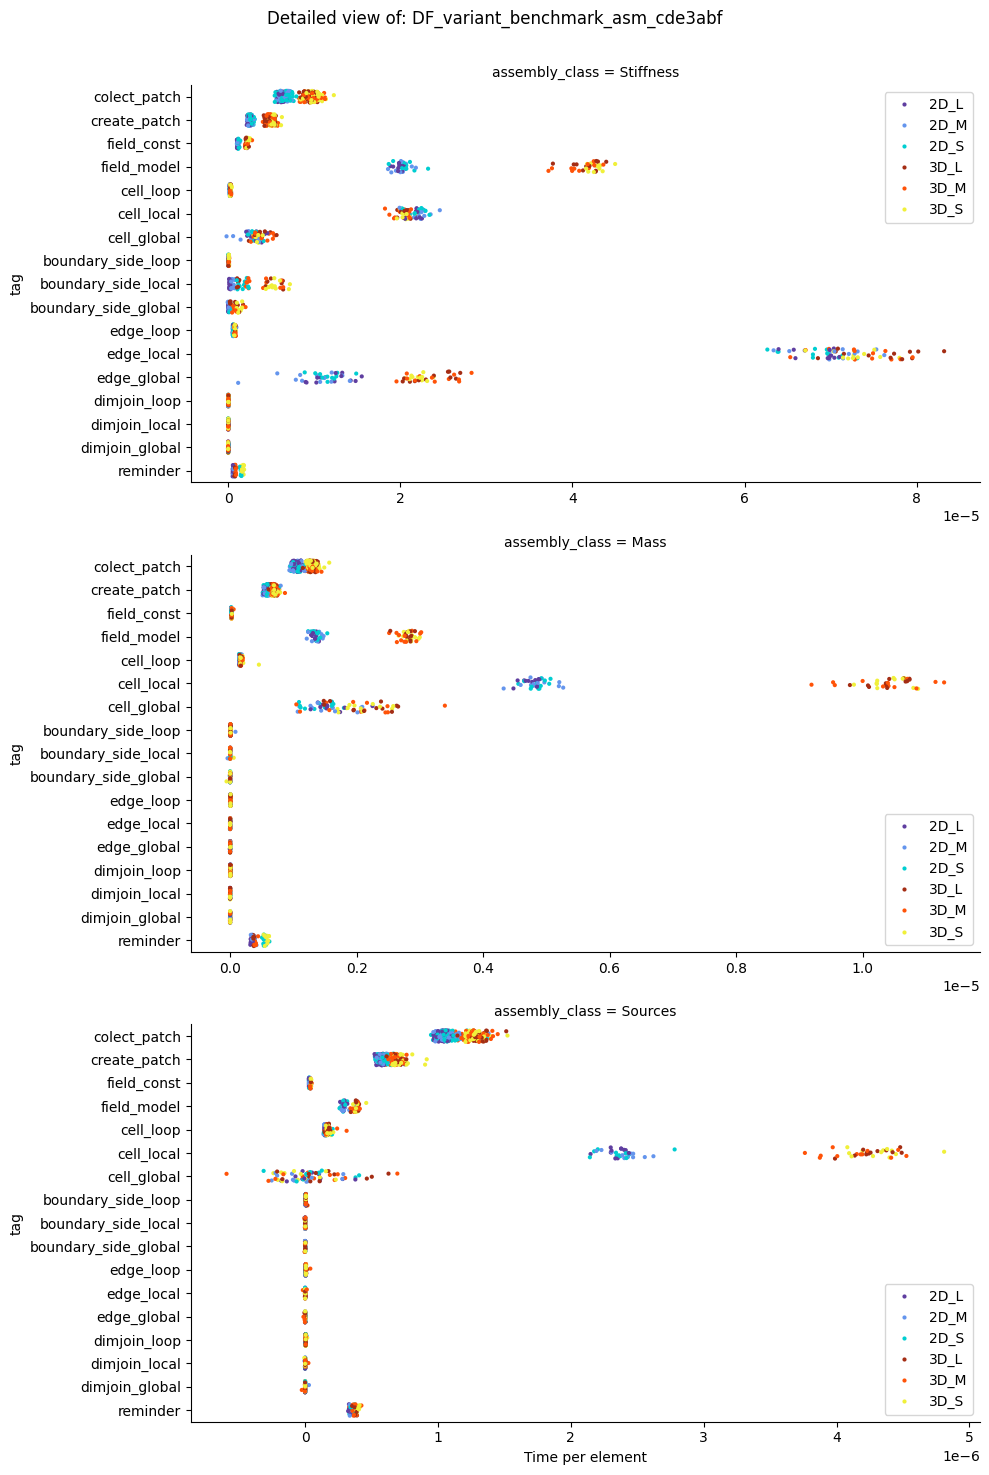

In [8]:
ddf = detail_df.copy()
ddf['dim_size'] = ddf['dim'] + '_' + ddf['size']
ddf['time'] = ddf['time'] / ddf['n_el']
#ddf.set_index(['assembly_class'], inplace=True)
#print(ddf.columns)
#print(detail_df['assembly_class'])

# Define custom colors matching structure of `dim_size` values
cold_tones = ['#5F3EA0', '#6495ED', '#00CED1'] 
warm_tones = ['#a42d14', '#ff5308', '#f0f03a', ] 
custom_palette = cold_tones + warm_tones
sns.set_palette(custom_palette)

facet_grid = sns.catplot(data=ddf, x='time', y='tag', hue='dim_size', row='assembly_class',
            kind='strip', orient='h', sharex=False, aspect=2, jitter=0.25, size=3,
            row_order=['Stiffness', 'Mass', 'Sources'],
            legend_out=False)

handles, labels = facet_grid.axes[2][0].get_legend_handles_labels()
#print(handles, labels)
for ax, loc in zip(facet_grid.axes.flatten(), [1,4,4]):
    ax.legend(handles, labels, loc=loc)
facet_grid.axes[2][0].set_xlabel("Time per element")
facet_grid.fig.subplots_adjust(top=0.93) # adjust the Figure in rp
facet_grid.fig.suptitle(f'Detailed view of: {flow123d_version}')

plt.savefig("detailed_plot.pdf")

## Interpretation

### Patch creation
- patch creation overhead is relatively small, comparable to field_model evaluation for matrix assemblies
- the overhead is much more significant for simple assembly like `Sources`
- the overhead in field evaluation and field access is not included, so in fact, the overhead could be higher 1.5 times

### Field evaluation
- It seems that evaluation of tensor-valued fields necessary in `Stiffness` is much more costly. Also, different kinds of fields are possibly in use.
- Constant value fields have negligible evaluation time.

### Assembly
- `<integral>_global` are calculated from noisy `<integral>_local` values, so it is noisy as well, leading to even negative values for fast vector-only assembly of `Sources`.
- Nevertheless, it is relatively costly for `Stiffness` and clearly correlated to the number of calls since it is higher for 3d meshes.
- Local evaluations are the highest in all three cases. Probably dominated by `FEValues.reinit` (according to VTUNE analysis).